In [1]:
import time
import argparse
from tqdm import tqdm

import pandas as pd

import torch
from torch.utils.data import DataLoader
import models
from torchvision.transforms import *

from datasets import *
from transforms import *

from utils import rlenc, rlenc_np, FasterRle, gzip_save

/wgdisk/st0008/hzh/workspace/tgs/venv_pytorch_saltnet/venv_pytorch_saltnet/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/wgdisk/st0008/hzh/workspace/tgs/venv_pytorch_saltnet/venv_pytorch_saltnet/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

In [3]:
from dataset_seam import SEAM

# dimension of raw image volume and order (y, x, z) with z fastest
ny = 1001; nx = 876; nz = 751;

# tile size for extraction
tile_size = 600

# tile skip
tile_skip = 10

# image
img_name = 'dataset_seam/Img.H@'

# velocity
vol_name = 'dataset_seam/Vo.H@'
    
seam = SEAM(img_name, tile_size=tile_size, tile_skip=tile_skip)

print(len(seam))

18368


(600, 600) 90_350_120


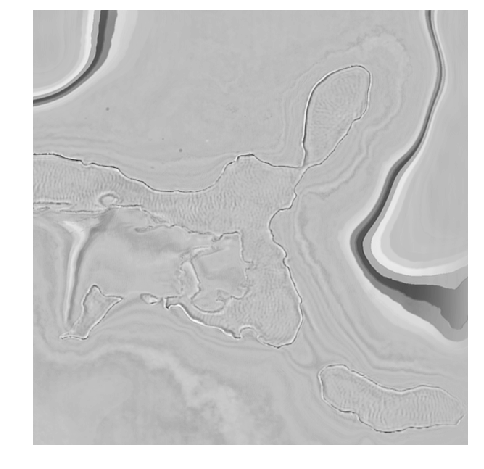

In [8]:
tile_index = 5000
tile = seam[tile_index]
data = tile['input']
print(data.shape, tile['image_id'])

#
plt.figure(figsize=(8,8))
plt.imshow(data.transpose(1,0), cmap='Greys')
plt.axis('off');

image shape: (751, 1001, 876), volume shape: (751, 1001, 876)


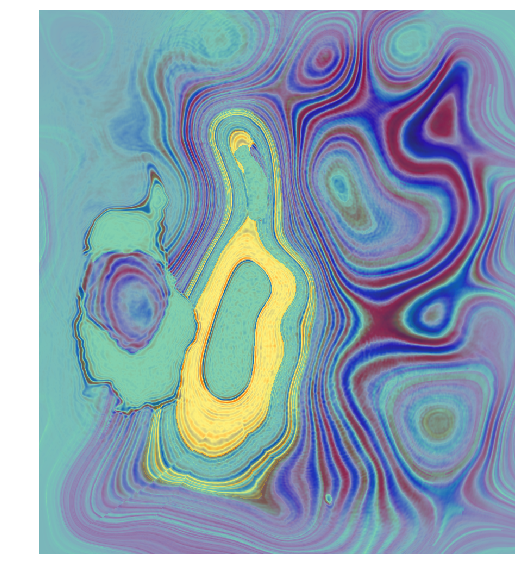

In [13]:
# SEAM dimension
nz=751; nx=876; ny=1001

#
tile_size = 101

# seed
np.random.seed(2019)
#
nz0 = np.arange(10, nz, 10)
iz0_randoms = np.random.permutation(nz)
ix0_randoms = np.random.permutation(nx-tile_size)
iy0_randoms = np.random.permutation(ny-tile_size)

# image
img_name = 'dataset_seam/Img.H@'
img = np.fromfile(img_name, dtype=np.float32).reshape(ny, nx, nz).transpose(2, 0, 1)

# velocity
vol_name = 'dataset_seam/Vo.H@'
vol = np.fromfile(vol_name, dtype=np.float32).reshape(ny, nx, nz).transpose(2, 0, 1)

# the shapes
print(f'image shape: {img.shape}, volume shape: {vol.shape}')

# 
plt.figure(figsize=(10, 10))
plt.imshow(img[500, :, :], cmap='seismic')
plt.imshow(vol[500, :, :], alpha=0.6)
plt.axis('off');

In [ ]:
orig_img_size = 101
img_size = 128
padding = compute_padding(orig_img_size, orig_img_size, img_size)
d_y0, d_y1, d_x0, d_x1 = padding
y0, y1, x0, x1 = d_y0, d_y0 + orig_img_size, d_x0, d_x0 + orig_img_size

In [ ]:
y0, y1, x0, x1

In [ ]:
def qc_test(args):
    """ for testing a small dataset """

    # test dataset
    test_transform = Compose([PrepareImageAndMask(),
                              ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    test_dataset = SEAM(mode='test', transform=test_transform, preload=False)
    
    # random indices
    indices = np.random.choice( len(test_dataset), args.batch_size)
    print(f'indices: {indices}')
    
    # picked test dataset
    test_dataset0 = torch.utils.data.Subset(test_dataset, indices)
    
    test_dataloader = DataLoader(test_dataset0, batch_size=args.batch_size, num_workers=args.dataload_workers_nums)
    test_dataloader_iter = iter(test_dataloader)

    # flipped test dataset
    flipped_test_transform = Compose([PrepareImageAndMask(), HorizontalFlip(),
                                      ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    flipped_test_dataset = SaltIdentification(mode='test', transform=flipped_test_transform, preload=False)
    
    # for flipped test dataset
    flipped_test_dataset0 = torch.utils.data.Subset(flipped_test_dataset, indices)
    
    flipped_test_dataloader_iter = iter(DataLoader(flipped_test_dataset0, batch_size=args.batch_size,
                                                   num_workers=args.dataload_workers_nums))

    model.eval()
    torch.set_grad_enabled(False)
    
    # test data
    batch = next(test_dataloader_iter)
    
    image_ids = batch['image_id']
    images = batch['input']

    # flipped data
    if args.tta:
        flipped_batch = next(flipped_test_dataloader_iter)
    else:
        flipped_batch = None

    # predicted probabilities
    probs = predict(args, model, batch, flipped_batch, use_gpu=use_gpu)

    # prediction
    pred = probs > args.threshold

    # output probabilities
    probs_uint16 = (65535 * probs).astype(dtype=np.uint16)

    # input images
    image_samples = images[:, :, y0:y1, x0:x1].permute(0, 2, 3, 1).numpy()
        
    return image_ids, pred, probs_uint16, image_samples


In [ ]:
parser = argparse.ArgumentParser(description=__doc__, formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--batch-size", type=int, default=30, help='batch size')
parser.add_argument("--dataload-workers-nums", type=int, default=8, help='number of workers for dataloader')
parser.add_argument('--tta', action='store_true', help='test time augmentation')
parser.add_argument('--seed', type=int, default=None, help='manual seed for deterministic')
parser.add_argument("--threshold", type=float, default=0.5, help='probability threshold')
parser.add_argument("--output-prefix", type=str, default='noprefix', help='prefix string for output files')
parser.add_argument('--resize', action='store_true', help='resize to 128x128 instead of reflective padding')
parser.add_argument("model", help='a pretrained neural network model')

# args examples
arg_commands = '--tta my_runs/models/best-metric-model-fold0.pth --output-prefix fold0'
args = parser.parse_args(arg_commands.split())
print(vars(args))

# execute the codes
use_gpu = torch.cuda.is_available()
print('use_gpu', use_gpu)

print("loading model...")
model = models.load(args.model)
model.float()

if use_gpu:
    if args.seed is not None:
        torch.manual_seed(args.seed)
        torch.backends.cudnn.deterministic = True
    else:
        torch.backends.cudnn.benchmark = True
    model.cuda()

print("testing %s..." % args.model)
start = time.time()
# the whole dataset
#test(args)
# show only a batch
image_ids, pred, probs_uint16, image_samples = qc_test(args)
time_elapsed = time.time() - start
time_str = 'total time elapsed: {:.0f}h {:.0f}m {:.0f}s '.format(time_elapsed // 3600,
                                                                 time_elapsed % 3600 // 60,
                                                                 time_elapsed % 60)
print(time_str)
print("finished")


In [ ]:
print(pred.shape, probs_uint16.shape, image_samples.shape)

In [ ]:

nrows = pred.shape[0]

plt.figure(figsize=(8, 3.5*nrows))

for i in range(nrows):
    # overlay two images
    plt.subplot(nrows, 3, i*3+1)
    plt.imshow(pred[i])
    # 
    plt.axis('off')
    #
    plt.subplot(nrows, 3, i*3+2)
    plt.imshow(image_samples[i], cmap='Greys')
    # 
    plt.axis('off')
    #
    plt.subplot(nrows, 3, i*3+3)
    plt.imshow(pred[i])
    plt.imshow(image_samples[i], alpha=0.4, cmap='Greys')
    # 
    plt.axis('off')

# plt.tight_layout()
plt.subplots_adjust(top=0.8, bottom=0.0, 
                    left=0.0, right=1.0, 
                    hspace=0.05, wspace=0.05)